In [51]:
!cat /proc/meminfo

MemTotal:       65951648 kB
MemFree:        36316056 kB
MemAvailable:   37901944 kB
Buffers:          650104 kB
Cached:          1341468 kB
SwapCached:            0 kB
Active:         28103084 kB
Inactive:         931632 kB
Active(anon):   27043144 kB
Inactive(anon):       60 kB
Active(file):    1059940 kB
Inactive(file):   931572 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:                56 kB
Writeback:             0 kB
AnonPages:      27043064 kB
Mapped:           193592 kB
Shmem:                72 kB
Slab:             361276 kB
SReclaimable:     319272 kB
SUnreclaim:        42004 kB
KernelStack:        8976 kB
PageTables:        61012 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    32975824 kB
Committed_AS:   32439296 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [1]:
!ls -la /bin

total 7252
dr-xr-xr-x  2 root root    4096 Sep 18 01:14 .
dr-xr-xr-x 26 root root    4096 Oct 24 15:38 ..
-rwxr-xr-x  1 root root   28448 Feb 25  2016 arch
lrwxrwxrwx  1 root root       4 Aug 11 01:26 awk -> gawk
-rwxr-xr-x  1 root root   28128 Feb 25  2016 basename
-rwxr-xr-x  1 root root  936000 Aug 30  2017 bash
-rwxr-xr-x  1 root root   48000 Feb 25  2016 cat
-rwxr-sr-x  1 root cgred  12112 Feb 28  2014 cgclassify
-rwxr-xr-x  1 root root   12744 Feb 28  2014 cgcreate
-rwxr-xr-x  1 root root   11528 Feb 28  2014 cgdelete
-rwxr-sr-x  1 root cgred  12200 Feb 28  2014 cgexec
-rwxr-xr-x  1 root root   15656 Feb 28  2014 cgget
-rwxr-xr-x  1 root root   12464 Feb 28  2014 cgset
-rwxr-xr-x  1 root root   15792 Feb 28  2014 cgsnapshot
-rwxr-xr-x  1 root root   57216 Feb 25  2016 chgrp
-rwxr-xr-x  1 root root   52992 Feb 25  2016 chmod
-rwxr-xr-x  1 root root   58496 Feb 25  2016 chown
-rwxr-xr-x  1 root root  145760 Feb 25  2016 cp
-rwxr-xr-x  1 root root  129912 Oct  8  2014 cpio
-rwxr-xr-

In [48]:
!pip install xgboost msgpack

    100% |████████████████████████████████| 15.8MB 3.3MB/s eta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from importlib import reload
import pandas as pd
import numpy as np
import io
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)
# from sklearn import preprocessing as prp

# custom functions and objects
from utils import *

# from utils.funcs import predict
# from utils.sample_strategies import stg2_sample, stg2_period_samples, stg2_sample_exclude, rfc_key_features_data

# import xgboost library
import xgboost as xgb

pd.options.display.max_rows = 4000

# ruta de trabajo en s3
bucket = 'boi-banregio'
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV'

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

## Selección de datasets

In [180]:
data1_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/STRATEGY1_PRP.csv"
data1_file_key = "{}/{}".format(prefix, data1_file_name)
data1_obj = s3_bucket_resource.Object(data1_file_key).get()
data1 = pd.read_csv(io.BytesIO(data1_obj['Body'].read()))

In [97]:
data1_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/STRATEGY1_ALL_PRP.csv"
data1_file_key = "{}/{}".format(prefix, data1_file_name)
data1_obj = s3_bucket_resource.Object(data1_file_key).get()
data1 = pd.read_csv(io.BytesIO(data1_obj['Body'].read()))

In [3]:
data2_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/STRATEGY2_PRP.csv"
data2_file_key = "{}/{}".format(prefix, data2_file_name)
data2_obj = s3_bucket_resource.Object(data2_file_key).get()
data2 = pd.read_csv(io.BytesIO(data2_obj['Body'].read()))

In [60]:
val_data_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/VALIDATION+201705.csv"
val_data_file_key = "{}/{}".format(prefix, val_data_file_name)
val_data_obj = s3_bucket_resource.Object(val_data_file_key).get()
val_data = pd.read_csv(io.BytesIO(val_data_obj['Body'].read()))

In [5]:
extra_features_file_name = 'DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/PARTITION/EXTRA_FEATURES/JAT_MCV_VAR_VARIABLES_DIASATRASO.csv'
extra_features_file_key = "{}/{}".format(prefix, extra_features_file_name)
extra_features_obj = s3_bucket_resource.Object(extra_features_file_key).get()
extra_features_data = pd.read_csv(io.BytesIO(extra_features_obj['Body'].read()))

## Selección de características

In [96]:
feat_sel_file_name = "DATASETS_3/JAT_MCV_VAR_VARIABLES_SELECCION/SAMPLES/FEATURE_SELECTION/LASSO_LOGIT.csv"
feat_sel_file_key = "{}/{}".format(prefix, feat_sel_file_name)
feat_sel_obj = s3_bucket_resource.Object(feat_sel_file_key).get()
feat_sel = pd.read_csv(io.BytesIO(feat_sel_obj['Body'].read()))

In [98]:
feature_data_sel = pd.concat(
    [data1[feat_sel['Feature']], extra_features_data[stg1_sample].reset_index(drop=True)], 
    axis=1
)
target = data1['BMI']

In [8]:
feature_data_sel = pd.concat(
    [data2[feat_sel['Feature']], extra_features_data[stg1_sample].reset_index(drop=True)], 
    axis=1
)
target = data2['BMI']

---

## Todas las características

In [181]:
feature_data_sel = pd.concat(
    [data1.iloc[:,3:], extra_features_data[stg1_sample].reset_index(drop=True)], 
    axis=1
)
target = data1['BMI']

In [10]:
feature_data_sel = pd.concat(
    [data2.iloc[:,3:], extra_features_data[stg2_sample].reset_index(drop=True)], 
    axis=1
)
target = data2['BMI']

## Selección con importancia de xgboost

In [160]:
# after feature selection by xgboost importance
feature_data_sel = feature_data_sel[features]

In [182]:
feature_data_sel.shape

(65753, 1914)

## Conjuntos de prueba y entrenamiento

In [183]:
np.random.seed(9)
rand_split = np.random.rand(len(target))
train_list = (rand_split > 0.2)
test_list = rand_split <= 0.2

feature_data_train = feature_data_sel[train_list]
feature_data_test = feature_data_sel[test_list]

target_data_train = target[train_list]
target_data_test = target[test_list]

In [184]:
train_y = target_data_train.values
test_y = target_data_test.values

train_X = feature_data_train.loc[:,:].values
test_X = feature_data_test.loc[:,:].values

dtrain = xgb.DMatrix(
    train_X, 
    label=train_y, 
    feature_names=feature_data_train.columns
)
dtest = xgb.DMatrix(
    test_X, 
    label=test_y, 
    feature_names=feature_data_test.columns
)

## Entrenamiento

In [201]:

# Trianing
version = 0
params = {
    'objective': 'binary:logistic', 
    # 'booster': 'dart',
    'eta':0.3, 
    'max_depth': 5, 
    'eval_metric': 'auc',
    # L1 regularization term (default 0)
    'alpha': 30,
    # L2 regularization term (default 1)
    'lambda': 1,
    # Minimum loss reduction (default 0)
    'gamma': 0.1,
    'scale_pos_weight': 1,
    # extremely imbalanced classes, control the update
    'max_delta_step': 5,
    # minimum sum of instance weight needed in a child (default 1)
    'min_child_weight': 1
    # 'rate_drop': 0.1,
    # 'skip_drop': 0.5,
    # 'seed': 1 # ,
#     'subsample': 0.5,
#     'max_delta_step': 10    
}

params_BAY = {
    'objective': 'binary:logistic', 
    'eta':0.05,
    'max_depth': 12, 
    'gamma': 0.001, 
    'min_child_weight': 10.108909877670685, 
    'max_delta_step': 2.4592238788322622, 
    'subsample': 1, 
    'colsample_bytree': 0.4,
    'seed': 1
}


num_round = 70

evals = [(dtest, 'eval')]

bst = xgb.train(params, dtrain, num_round, evals, feval=val_func)
# bst = xgb.train(params, dtrain, num_round, evals, feval=val_func, xgb_model=bst)
  
feat_imp = get_xgb_feat_importances(bst)
display(feat_imp)

#pickle.dump(bst, open('models/pickles/cartera_vencida_version{}.pckl.model'.format(version),"wb"))
#feat_imp.to_csv('models/feature_importances_version{}.csv'.format(version), index=False)

[01:10:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[0]	eval-auc:0.764168	eval-f1_score_thr0.2:0.073715	eval-f1_score_thr0.3:0.073715	eval-f1_score_thr0.4:0.438185	eval-f1_score_thr0.5:0.341985	eval-f1_score_thr0.6:0	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[01:10:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1]	eval-auc:0.782041	eval-f1_score_thr0.2:0.073715	eval-f1_score_thr0.3:0.405641	eval-f1_score_thr0.4:0.449629	eval-f1_score_thr0.5:0.391241	eval-f1_score_thr0.6:0.31875	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[01:10:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.81511	eval-f1_score_thr0.2:0.360105	eval-f1_score_thr0.3:0.430224	eval-f1_score_thr0.4:0.455668	eval-f1_score_thr0.5:0.395954	eval-f1_score_thr0.6:0.339969	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[01:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[3]	eval-auc:0.847696	eval-f1_score_thr0.2:0.41204	eval-f1_score_thr0.3:0.450758	eval-f1_score_thr0.4:0.456311	eval-f1_score_thr0.5:0.413598	eval-f1_score_thr0.6:0.360061	eval-f1_score_thr0.7:0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[01:10:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[4]	eval-auc:0.846532	eval-f1_score_thr0.2:0.423131	eval-f1_score_thr0.3:0.451613	eval-f1_score_thr0.4:0.453634	eval-f1_score_thr0.5:0.411429	eval-f1_score_thr0.6:0.36391	eval-f1_score_thr0.7:0.130435
[01:10:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[5]	eval-auc:0.87487	eval-f1_score_thr0.2:0.45066	eval-f1_score_thr0.3:0.456842	eval-f1_score_thr0.4:0.451531	eval-f1_score_thr0.5:0.415363	eval-f1_score_thr0.6:0.362538	eval-f1_score_thr0.7:0.157143
[01:10:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=5
[6]	eval-auc:0.889057	eval-f1_score_thr0.2:0.4583	eval-f1_score_thr0.3:0.462703	eval-f1_score_thr0.4:0.460358	eval-f1_score_thr0.5:0.415363	eval-f1_score_thr0.6:0.369925	eval-f1_score_thr0.7:0.169611
[01:10:17] /workspace/src/tree

[01:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[30]	eval-auc:0.943664	eval-f1_score_thr0.2:0.517241	eval-f1_score_thr0.3:0.513514	eval-f1_score_thr0.4:0.496984	eval-f1_score_thr0.5:0.453083	eval-f1_score_thr0.6:0.393539	eval-f1_score_thr0.7:0.305958
[01:10:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[31]	eval-auc:0.944136	eval-f1_score_thr0.2:0.517688	eval-f1_score_thr0.3:0.510949	eval-f1_score_thr0.4:0.498789	eval-f1_score_thr0.5:0.457831	eval-f1_score_thr0.6:0.386431	eval-f1_score_thr0.7:0.308682
[01:10:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=5
[32]	eval-auc:0.944598	eval-f1_score_thr0.2:0.516854	eval-f1_score_thr0.3:0.51875	eval-f1_score_thr0.4:0.502415	eval-f1_score_thr0.5:0.456	eval-f1_score_thr0.6:0.389956	eval-f1_score_thr0.7:0.309179
[01:10:35] /workspace/src/

[01:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[56]	eval-auc:0.947438	eval-f1_score_thr0.2:0.520851	eval-f1_score_thr0.3:0.534979	eval-f1_score_thr0.4:0.507784	eval-f1_score_thr0.5:0.458886	eval-f1_score_thr0.6:0.407569	eval-f1_score_thr0.7:0.338073
[01:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[57]	eval-auc:0.947288	eval-f1_score_thr0.2:0.523444	eval-f1_score_thr0.3:0.535934	eval-f1_score_thr0.4:0.506603	eval-f1_score_thr0.5:0.462963	eval-f1_score_thr0.6:0.414493	eval-f1_score_thr0.7:0.342767
[01:10:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[58]	eval-auc:0.947439	eval-f1_score_thr0.2:0.52292	eval-f1_score_thr0.3:0.537037	eval-f1_score_thr0.4:0.502994	eval-f1_score_thr0.5:0.464993	eval-f1_score_thr0.6:0.417391	eval-f1_score_thr0.7:0.348509
[01:10:52] /workspace/s

,Feature,Importance
0,MS_OP,0.023324
1,DS_CL,0.020408
2,BK_DEUDA_CP,0.015549
3,DIAS_ATRASO,0.013605
4,DPCV_CAP,0.012634
5,PCT_CL_ACC,0.012634
6,R_BAL_BY_CRED_LIM,0.009718
7,MIN_R_BAL_BY_CRED_LIM_12M,0.009718
8,MAX_MS_OP_OP_ACC,0.008746
9,AVG_MS_OP_OP_ACC,0.008746


In [159]:
features = list(feat_imp['Feature'])
len(features)

315

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


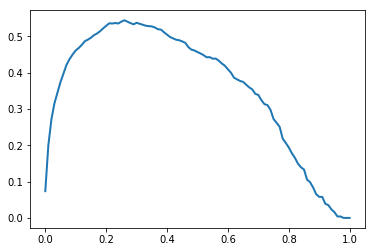

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


threshold 0.26
max f1_score 0.544390243902439
eta 0.3
max_depth 5
num_round 70


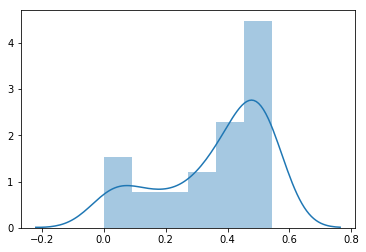

In [202]:
f1_sc = 0
max_step = 0
thr_sample = (dtest, test_y)
_score_preds = bst.predict(thr_sample[0], ntree_limit=bst.best_ntree_limit)
scores = []
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(_score_preds, thr_step)
    f1_sc_step = f1_score(thr_sample[1], _preds)
    #print(thr_step, f1_sc_step)
    scores.append(f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
plt.plot(np.linspace(0, 1, 101), scores, linewidth=2.0)
plt.show()
sns.distplot(scores)

threshold = max_step
print('threshold', threshold)
print('max f1_score', f1_sc)
print('eta', params['eta'])
print('max_depth', params['max_depth'])
print('num_round', bst.best_ntree_limit)

In [12]:
import pickle

missing_cols = pickle.load(open("pickles/stg1_missing_cols.data", "rb")) 
imputer = pickle.load(open("pickles/stg1_imputer.data", "rb"))
scaler = pickle.load(open("pickles/stg1_scaler.data", "rb"))

In [59]:
import pickle

# missing_cols = pickle.load(open("pickles/stg1_missing_cols.data", "rb")) 
imputer = pickle.load(open("pickles/stg1_all_imputer.data", "rb"))
scaler = pickle.load(open("pickles/stg1_all_scaler.data", "rb"))

In [19]:
import pickle

missing_cols = pickle.load(open("pickles/stg2_missing_cols.data", "rb")) 
imputer = pickle.load(open("pickles/stg2_imputer.data", "rb"))
scaler = pickle.load(open("pickles/stg2_scaler.data", "rb"))

In [22]:
val_data = val_data.drop(missing_cols, axis=1)

In [61]:
val_data.iloc[:,3:] = imputer.transform(val_data.iloc[:,3:].values)
val_data.iloc[:,3:] = scaler.transform(val_data.iloc[:,3:].values)

---

In [33]:
validacion = rfc_key_features_data['FECHA'] > 201705
display(validacion.sum())

val_data_sel = pd.concat(
    [val_data[feat_sel['Feature']], extra_features_data[validacion].reset_index(drop=True)], 
    axis=1
)
val_target = val_data['BMI']

82377

---

In [192]:
# local constrain for validation set
local_constrain = (rfc_key_features_data[rfc_key_features_data['FECHA'] > 201705]['FECHA'] > 201705).reset_index(drop=True)

val_data_sel = pd.concat(
    [val_data.iloc[:,3:], extra_features_data[rfc_key_features_data['FECHA'] > 201705].reset_index(drop=True)], 
    axis=1
)[local_constrain][feature_data_sel.columns]

val_target = val_data[local_constrain]['BMI']

In [193]:
val_y = val_target.values
val_X = val_data_sel.values

dval = xgb.DMatrix(
    val_X, 
    label=val_y, 
    feature_names=val_data_sel.columns
)

In [ ]:
#after feature selection by xgboost importance
val_data_sel = val_data_sel[features]

In [203]:
# make predictions on datasets
train_pred = predict(bst.predict(dtrain), threshold)
test_pred = predict(bst.predict(dtest), threshold)
val_pred = predict(bst.predict(dval), threshold)

cm_train = confusion_matrix(train_y, train_pred)
#cm_train = confusion_matrix(y_resampled, train_pred)
cm_test = confusion_matrix(test_y, test_pred)
cm_val = confusion_matrix(val_y, val_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()*100
cm_test_pct = cm_test / cm_test.astype(np.float).sum()*100
cm_val_pct = cm_val / cm_val.astype(np.float).sum()*100

summary = [
    ['------', 'Train', 'Test', 'Validation'],
    ['confusion matrix', cm_train, cm_test, cm_val],
    ['confusion matrix pct', cm_train_pct, cm_test_pct, cm_val_pct],
    ['f1_score', f1_score(train_y, train_pred), f1_score(test_y, test_pred), f1_score(val_y, val_pred)],    
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(test_y, test_pred), accuracy_score(val_y, val_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(test_y, test_pred), recall_score(val_y, val_pred)],
    ['precision_score', precision_score(train_y, train_pred),  precision_score(test_y, test_pred), precision_score(val_y, val_pred)]
]

# print pretty table
print('thr', threshold)
print('iter', bst.best_ntree_limit)
pretty_table(summary)
print(params)


thr 0.26
iter 70
------              	Train                      	Test                       	Validation                 
confusion matrix    	[[49778   777]             	[[12372   244]             	[[77301  1799]             
                    	 [  696  1384]]            	 [  223   279]]            	 [ 1655  1622]]            
confusion matrix pct	[[94.57205282  1.47620405] 	[[94.31315749  1.86003964] 	[[93.83808587  2.183862  ] 
                    	 [ 1.32231405  2.62942909]]	 [ 1.69995426  2.1268486 ]]	 [ 2.00905593  1.9689962 ]]
f1_score            	0.6526762556000943         	0.544390243902439          	0.4843236787100627         
accuracy score      	0.9720148190367626         	0.9644000609849063         	0.9580708207387985         
recall score        	0.6653846153846154         	0.5557768924302788         	0.49496490692706746        
precision_score     	0.6404442387783433         	0.5334608030592735         	0.47413037123648055        
{'objective': 'binary:logistic', 'eta'

In [158]:
for month in [201706, 201707, 201708, 201709, 201710, 201711]:
    # local constrain for validation set

    local_constrain = (rfc_key_features_data[rfc_key_features_data['FECHA'] > 201705]['FECHA'] == month).reset_index(drop=True)

    val_data_sel = pd.concat(
        [val_data.iloc[:,3:], extra_features_data[rfc_key_features_data['FECHA'] > 201705].reset_index(drop=True)], 
        axis=1
    )[local_constrain][feature_data_sel.columns]

    val_target = val_data[local_constrain]['BMI']


    val_y = val_target.values
    val_X = val_data_sel.values

    dval = xgb.DMatrix(
        val_X, 
        label=val_y, 
        feature_names=val_data_sel.columns
    )

    # make predictions on datasets

    val_pred = predict(bst.predict(dval), threshold)


    cm_val = confusion_matrix(val_y, val_pred)

    cm_val_pct = cm_val / cm_val.astype(np.float).sum()*100

    summary = [
        ['------', 'Validation'],
        ['confusion matrix',  cm_val],
        ['confusion matrix pct',  cm_val_pct],
        ['f1_score',  f1_score(val_y, val_pred)],    
        ['accuracy score',  accuracy_score(val_y, val_pred)],
        ['recall score',  recall_score(val_y, val_pred)],
        ['precision_score',  precision_score(val_y, val_pred)]
    ]

    # print pretty table
    print('-----------------------------------------------------\n')
    print("validacion = {}\n".format(str(month)))
    print('thr', threshold)
    print('iter', bst.best_ntree_limit)
    pretty_table(summary)
    print('\n\n')


-----------------------------------------------------

validacion = 201706

thr 0.25
iter 70
------              	Validation                 
confusion matrix    	[[12620   340]             
                    	 [  280   276]]            
confusion matrix pct	[[93.37081977  2.51553714] 
                    	 [ 2.07161882  2.04202427]]
f1_score            	0.4709897610921502         
accuracy score      	0.9541284403669725         
recall score        	0.49640287769784175        
precision_score     	0.44805194805194803        



-----------------------------------------------------

validacion = 201707

thr 0.25
iter 70
------              	Validation                 
confusion matrix    	[[12697   351]             
                    	 [  295   291]]            
confusion matrix pct	[[93.12747543  2.57444624] 
                    	 [ 2.16370838  2.13436996]]
f1_score            	0.4739413680781759         
accuracy score      	0.9526184538653366         
recall score        	0.4965